# Obtain and decompress data

Note: Uncomment this section if the data has not been download and extracted. 

In [1]:
# #Download the dataset from opensig
# import urllib.request
# urllib.request.urlretrieve('http://opendata.deepsig.io/datasets/2016.10/RML2016.10a.tar.bz2', 'RML2016.10a.tar.bz2')

In [2]:
# #decompress the .bz2 file into .tar file
# import sys
# import os
# import bz2

# zipfile = bz2.BZ2File('./RML2016.10a.tar.bz2') # open the file
# data = zipfile.read() # get the decompressed data

In [3]:
# #write the .tar file
# open('./RML2016.10a.tar', 'wb').write(data) # write a uncompressed file

In [4]:
# #extract the .tar file
# import tarfile
# my_tar = tarfile.open('./RML2016.10a.tar')
# my_tar.extractall('./') # specify which folder to extract to
# my_tar.close()

In [3]:
#extract the pickle file
import pickle
import numpy as np
Xd = pickle.load(open("RML2016.10a_dict.pkl",'rb'),encoding="bytes")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
print(mods)

[b'8PSK', b'AM-DSB', b'AM-SSB', b'BPSK', b'CPFSK', b'GFSK', b'PAM4', b'QAM16', b'QAM64', b'QPSK', b'WBFM']


# Import libraries

In [4]:
# Import all libraries used for this NN development
%matplotlib inline
import random
import tensorflow.keras.utils
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras
import pandas as pd
from sklearn import preprocessing
import time

# Plot 18dB SNR sample for each modulation type

Text(0.5, 1.0, 'WBFM')

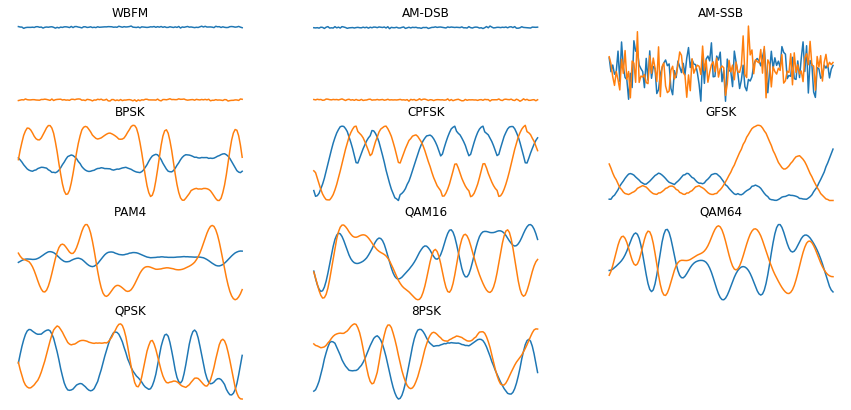

In [5]:
#Plot one sample from each of the the 11 Modulations (use index 1 of the 18dB SNR for each modulation label)
plt.figure(figsize = (15, 7))
plt.subplot(4,3,11)
plt.axis('off')
plt.box('on')
xx = Xd[(b'8PSK', 18)][1]
plt.plot(xx[0])
plt.plot(xx[1])
plt.title('8PSK')

plt.subplot(4,3,2)
plt.axis('off')
plt.box('on')
xx = Xd[(b'AM-DSB', 18)][1]
plt.plot(xx[0])
plt.plot(xx[1])
plt.title('AM-DSB')

plt.subplot(4,3,3)
plt.axis('off')
plt.box('on')
xx = Xd[(b'AM-SSB', 18)][1]
plt.plot(xx[0])
plt.plot(xx[1])
plt.title('AM-SSB')

plt.subplot(4,3,4)
plt.axis('off')
plt.box('on')
xx = Xd[(b'BPSK', 18)][1]
plt.plot(xx[0])
plt.plot(xx[1])
plt.title('BPSK')

plt.subplot(4,3,5)
plt.axis('off')
plt.box('on')
xx = Xd[(b'CPFSK', 18)][1]
plt.plot(xx[0])
plt.plot(xx[1])
plt.title('CPFSK')

plt.subplot(4,3,6)
plt.axis('off')
plt.box('on')
xx = Xd[(b'GFSK', 18)][1]
plt.plot(xx[0])
plt.plot(xx[1])
plt.title('GFSK')

plt.subplot(4,3,7)
plt.axis('off')
plt.box('on')
xx = Xd[(b'PAM4', 18)][2]
plt.plot(xx[0])
plt.plot(xx[1])
plt.title('PAM4')

plt.subplot(4,3,8)
plt.axis('off')
plt.box('on')
xx = Xd[(b'QAM16', 18)][1]
plt.plot(xx[0])
plt.plot(xx[1])
plt.title('QAM16')

plt.subplot(4,3,9)
plt.axis('off')
plt.box('on')
xx = Xd[(b'QAM64', 18)][1]
plt.plot(xx[0])
plt.plot(xx[1])
plt.title('QAM64')

plt.subplot(4,3,10)
plt.axis('off')
plt.box('on')
xx = Xd[(b'QPSK', 18)][1]
plt.plot(xx[0])
plt.plot(xx[1])
plt.title('QPSK')

plt.subplot(4,3,1)
plt.axis('off')
plt.box('on')
xx = Xd[(b'WBFM', 18)][1]
plt.plot(xx[0])
plt.plot(xx[1])
plt.title('WBFM')

# Partition and Format Input Data and Labels

In [6]:
# Partition the data
#  into training and test sets of the form we can train/test on 
np.random.seed(2020)
n_examples = X.shape[0]
n_train = n_examples // 2
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]

In [7]:
#one-hot encoding the label
lb = preprocessing.LabelBinarizer()
lb.fit(np.asarray(lbl)[:,0])
print(lb.classes_)
lbl_encoded=lb.transform(np.asarray(lbl)[:,0])
y_train=lbl_encoded[train_idx]
y_test=lbl_encoded[test_idx]

[b'8PSK' b'AM-DSB' b'AM-SSB' b'BPSK' b'CPFSK' b'GFSK' b'PAM4' b'QAM16'
 b'QAM64' b'QPSK' b'WBFM']


In [8]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


# Build Neural Network

In [10]:
#Simple Network

dr = 0.6
model = models.Sequential()
model.add(Reshape(in_shp+[1], input_shape=in_shp))
model.add(ZeroPadding2D((0,5)))
model.add(Convolution2D(256, (1,5), activation="relu", kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0,1)))
model.add(Convolution2D(128, (2,3), activation="relu", kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0,3)))
model.add(Convolution2D(128, (1,5), activation="relu", kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0,3)))
model.add(Convolution2D(128, (1,5), activation="relu", kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(dr))
model.add(Dense(len(classes), activation='softmax', kernel_initializer='he_normal'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 2, 128, 1)         0         
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 2, 138, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 134, 256)       1536      
_________________________________________________________________
dropout_5 (Dropout)          (None, 2, 134, 256)       0         
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 2, 136, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 134, 128)       196736    
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 134, 128)      

In [11]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

# Train Neural Network

Note: This trains ona GTX1060 GPU in 40 minutes. This takes much longer on JupyterHub with no GPU acceleration 1784s/Epoch (30min/epoch). 

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [13]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'CNN.wts.h5'
t_0=time.time()

history = model.fit(X_train,
    y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_valid, y_valid),
    callbacks = [
        tensorflow.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='auto')
    ])
delta_t=time.time()-t_0
print(delta_t)
# we re-load the best weights once training is finished
model.load_weights(filepath)

Train on 88000 samples, validate on 22000 samples
Epoch 1/100
88000/88000 - 1784s - loss: 2.3543 - accuracy: 0.1125 - val_loss: 2.1662 - val_accuracy: 0.1668
Epoch 2/100
88000/88000 - 1778s - loss: 2.1160 - accuracy: 0.2091


KeyboardInterrupt: 

# Evaluate and Plot Model Performance

In [ ]:
# Show and time simple version of performance

t_0=time.time()
score = model.evaluate(X_test, y_test, verbose=0, batch_size=batch_size)
print(score)
delta_t=time.time()-t_0
print(delta_t)

In [ ]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()
plt.xlabel('# Epochs')
plt.ylabel('Cross-Entropy Loss')

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Get the test accuracy for different SNRs
acc = {}
acc_array=[]

snr_array=np.asarray(lbl)[:,1]
lb_temp = preprocessing.LabelBinarizer()
lb_temp.fit(snr_array)
temp_array=lb_temp.classes_
snr_label_array = []

#Resort the labels to put SNR labels in order
snr_label_array.append(temp_array[6])
snr_label_array.append(temp_array[4])
snr_label_array.append(temp_array[3])
snr_label_array.append(temp_array[2])
snr_label_array.append(temp_array[1])
snr_label_array.append(temp_array[0])
snr_label_array.append(temp_array[9])
snr_label_array.append(temp_array[8])
snr_label_array.append(temp_array[7])
snr_label_array.append(temp_array[5])
snr_label_array.append(temp_array[10])
snr_label_array.append(temp_array[16])
snr_label_array.append(temp_array[17])
snr_label_array.append(temp_array[18])
snr_label_array.append(temp_array[19])
snr_label_array.append(temp_array[11])
snr_label_array.append(temp_array[12])
snr_label_array.append(temp_array[13])
snr_label_array.append(temp_array[14])
snr_label_array.append(temp_array[15])

#print(snr_label_array)
y_test_snr=snr_array[test_idx]

#Obtain and print accuracy for each SNR. Categorize the acccuracy for each label and SNR
acc_label_snr = np.ones(len(classes))
for snr in snr_label_array:
    test_X_i = X_test[np.where(y_test_snr==snr)]
    test_Y_i = y_test[np.where(y_test_snr==snr)]
    
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
    #plt.figure()
    #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor),"for SNR",snr)
    acc[snr] = 1.0*cor/(cor+ncor)
    acc_array.append(1.0*cor/(cor+ncor))
    
    acc_label_snr  = np.vstack((acc_label_snr , np.divide(np.diag(conf),np.sum(conf, axis=0))))
acc_label_snr = np.delete(acc_label_snr, 0, 0)



In [ ]:
# Plot confusion matrix for all data
plt.figure()
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes, title='All SNR')


# Plot confusion matrix for 18dB SNR
plt.figure()
X_test_extracted = np.vstack((X_test[np.where(y_test_snr==np.bytes_('10'))], X_test[np.where(y_test_snr==np.bytes_('12'))], X_test[np.where(y_test_snr==np.bytes_('14'))], X_test[np.where(y_test_snr==np.bytes_('16'))], X_test[np.where(y_test_snr==np.bytes_('18'))]))
y_test_extracted = np.vstack((y_test[np.where(y_test_snr==np.bytes_('10'))], y_test[np.where(y_test_snr==np.bytes_('12'))], y_test[np.where(y_test_snr==np.bytes_('14'))], y_test[np.where(y_test_snr==np.bytes_('16'))], y_test[np.where(y_test_snr==np.bytes_('18'))]))

test_Y_hat = model.predict(X_test_extracted, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test_extracted.shape[0]):
    j = list(y_test_extracted[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes, title='SNR = 10dB to 18dB')


# Plot confusion matrix for 0dB SNR
plt.figure()
X_test_extracted = X_test[np.where(y_test_snr==np.bytes_('0'))]
y_test_extracted = y_test[np.where(y_test_snr==np.bytes_('0'))]

test_Y_hat = model.predict(X_test_extracted, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test_extracted.shape[0]):
    j = list(y_test_extracted[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes, title='SNR = 0dB')


# Plot confusion matrix for -10 to 0 dB SNR
plt.figure()
X_test_extracted = np.vstack((X_test[np.where(y_test_snr==np.bytes_('-10'))], X_test[np.where(y_test_snr==np.bytes_('-8'))], X_test[np.where(y_test_snr==np.bytes_('-6'))], X_test[np.where(y_test_snr==np.bytes_('-4'))], X_test[np.where(y_test_snr==np.bytes_('-2'))], X_test[np.where(y_test_snr==np.bytes_('0'))]))
y_test_extracted = np.vstack((y_test[np.where(y_test_snr==np.bytes_('-10'))], y_test[np.where(y_test_snr==np.bytes_('-8'))], y_test[np.where(y_test_snr==np.bytes_('-6'))], y_test[np.where(y_test_snr==np.bytes_('-4'))], y_test[np.where(y_test_snr==np.bytes_('-2'))], y_test[np.where(y_test_snr==np.bytes_('0'))]))

test_Y_hat = model.predict(X_test_extracted, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test_extracted.shape[0]):
    j = list(y_test_extracted[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes, title='SNR = -10dB to 0dB')

In [ ]:
#Print Table of average error for each SNR and Label
fig = plt.figure(figsize = (15, 7))
ax = plt.subplot(111)
# fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
df = pd.DataFrame(acc_label_snr)
df = df.round(decimals = 2)
table = ax.table(cellText = df.values, rowLabels=snr_label_array, colLabels=classes, colWidths=[0.075 for x in classes], loc='center')
table.auto_set_font_size(False)
table.set_fontsize(14)
fig.tight_layout()
# print(df.to_latex(index=False))

In [ ]:
# Show loss curves 
plt.figure()
plt.title('Accuracy vs SNRs')
plt.plot(np.arange(-20,20,2), acc_array)
plt.ylabel("Accuracy")
plt.xlabel('SNR [dB]')
plt.grid('on')